In [168]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import yasa

from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics 
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

events = np.loadtxt('p1_high1_trig.txt', delimiter=',')
# events = np.squeeze(events.values.tolist())
data = np.loadtxt('p1_high1.txt', delimiter=',')

print(events.shape, data.shape)

fs = 256
window_size = 77
channels = 8

(39032,) (39032, 8)


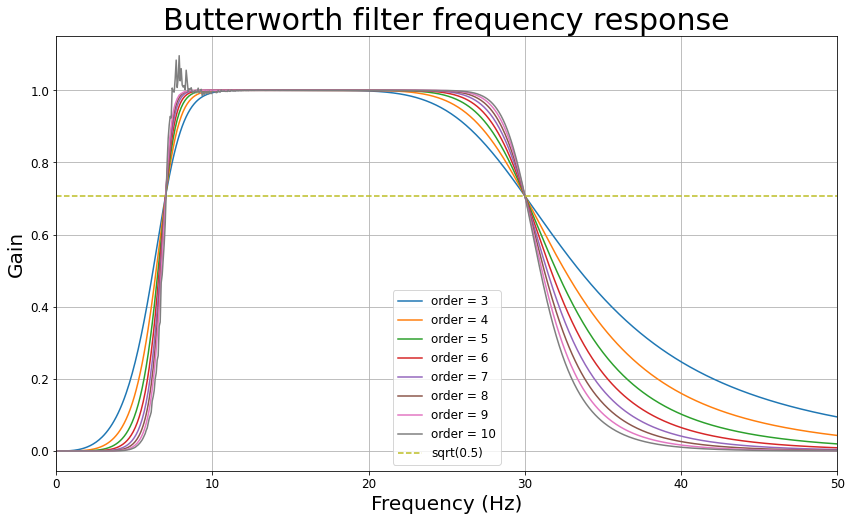

In [169]:
from scipy.signal import welch, freqz, butter, filtfilt

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y


# Plot frequency response, spectrum for unfiltered, test it on C3

# Define band
low = 7
high = 30

# Frequency response
plt.figure(1, figsize=(14, 8))
plt.clf()
for order in [3, 4, 5, 6, 7, 8, 9, 10]:
    b, a = butter_bandpass(low-margin, high+margin, fs, order=order)
    w, h = freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
plt.title("Butterworth filter frequency response", fontsize=30)
plt.xlabel('Frequency (Hz)', fontsize=20)
plt.xlim([0, 50])
plt.ylabel('Gain', fontsize=20)
plt.grid(True)
plt.legend(loc='best')



In [170]:
# for i in range(data.shape[1]):
#     data[:, i] = butter_bandpass_filter(data[:, i], low, high, fs, order=9)


In [171]:
non_target = np.zeros((channels, window_size))
target = np.zeros((channels, window_size))

non_target_count = 0 
target_count = 0

avg_non_target = np.zeros((channels, window_size))
avg_target = np.zeros((channels, window_size))

for i in range(events.shape[0]):
    if (events[i] == 1):
        non_target_count += 1
        trial = data[i: i + window_size, :].T
        non_target = np.append(non_target, trial, axis=1)
        avg_non_target += trial
        
    elif (events[i] == 2):
        target_count += 1
        trial = data[i: i + window_size, :].T
        target = np.append(target, trial, axis=1)
        avg_target += trial
    
    
avg_non_target /= non_target_count
non_target = non_target[:, window_size:]

avg_target /= target_count
target = target[:, window_size:]

all_trials = np.append(target, non_target, axis=1)

print(non_target.shape, all_trials.shape, target_count, non_target_count)

(8, 4620) (8, 9240) 60 60


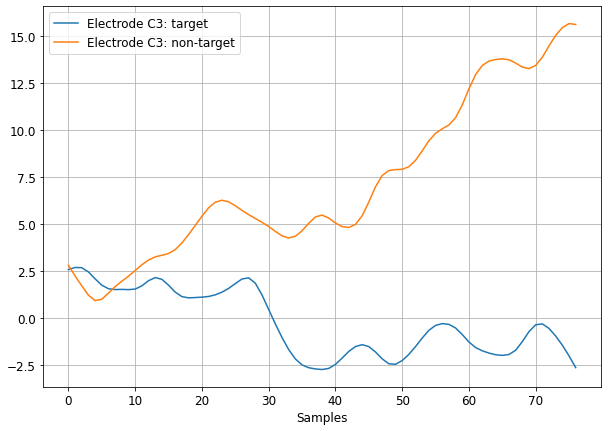

In [172]:
# plot
time = [i for i in range(window_size)]

plt.figure(1, figsize=(10, 7))
plt.clf()
plt.plot(time, avg_target[1, :], label='Electrode C3: target')
plt.plot(time, avg_non_target[1, :], label='Electrode C3: non-target' )

plt.xlabel('Samples')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')

plt.show()

In [231]:
# Create function to process eeg
b = window_size
bp_trials = np.zeros((8, 1))

while (b <= all_trials.shape[1]):
    data = all_trials[:, b-window_size:b]
    data_bp = yasa.bandpower(data, fs, relative=False)['TotalAbsPow']
    data_bp = data_bp.values.reshape((data_bp.shape[0], 1))
    bp_trials = np.append(bp_trials, data_bp, axis=1)
    
    b += 35
bp_trials = bp_trials[:, 1:]
print(bp_trials.shape)
print(bp_trials)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 1024 is greater than input length  = 77, using nperseg = 77
  warnings.warn('nperseg = {0:d} is greater than input length '


(8, 262)
[[  38.19877974   45.89217163   69.82560702 ...  559.56867348
   265.75243469  393.14309335]
 [  86.26336014 4151.58901894  105.54498506 ...  431.3079605
   269.04904487  516.93218031]
 [  35.90381117  208.31739491   42.14260299 ...  303.84534096
   173.21207095   63.26192251]
 ...
 [  57.28961276  783.28107829   42.60234598 ...  376.78678744
   179.10751108   19.36394417]
 [  41.9381238   395.08915798   45.11456141 ...  242.82280025
   308.83972661  276.30591383]
 [  57.69478388  465.76888139   79.57757278 ...  118.37345079
   151.77406473   34.67513166]]


In [232]:
half1 = bp_trials[:, int(bp_trials.shape[1]/2):]
half2 = bp_trials[:, :int(bp_trials.shape[1]/2)]

bp_trials[:, 0::2] = half1
bp_trials[:, 1::2] = half2

# create y vector
y = np.empty(bp_trials.shape[1], dtype='int8')
y[0::2] = np.ones(int(bp_trials.shape[1]/2))
y[1::2] = np.zeros(int(bp_trials.shape[1]/2))
print(y.shape, bp_trials.shape)

(262,) (8, 262)


[[21 58]
 [25 54]]


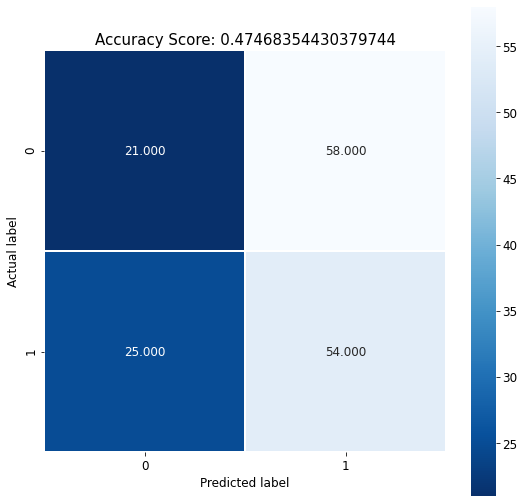

In [235]:
# classify

x_train, x_test, y_train, y_test = train_test_split(bp_trials.T, y, test_size=0.6, shuffle=False, random_state=1)

scaler = StandardScaler()
scaler.fit(x_train)    
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

model = LinearDiscriminantAnalysis() # Change your model here!
model.fit(x_train, y_train)

# Make predictions on entire test set
predictions = model.predict(x_test)

# Use score method to get accuracy of model
score = model.score(x_test, y_test)

# Confusion matrix
cm = metrics.confusion_matrix(y_test, predictions)
print(cm)

# Plot confusion matrix
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {1}'.format("Neural Net", score)
plt.title(all_sample_title, size = 15);